## Setup
This notebook requires some packages besides pytorch-lightning.

In [1]:
! pip install --quiet "matplotlib" "ipython[notebook]" "torchvision" "setuptools==59.5.0" "torch>=1.8" "torchmetrics>=0.7" "pytorch-lightning>=1.4"

## Barlow Twins

Barlow Twins finds itself in unique place amongst the current state-of-the-art self-supervised learning methods. It does not fall under the existing categories of contrastive learning, knowledge distillation or clustering based methods. Instead, it creates its own category of redundancy reductionand achieves competitive performance with a simple yet effective loss function.

In [4]:
from functools import partial
from typing import Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from sklearn.metrics import f1_score
import torchvision.transforms as transforms
import torchvision.transforms.functional as VisionF
from pytorch_lightning import Callback, LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import Tensor
from torch.utils.data import DataLoader ,TensorDataset
from torchmetrics.functional import accuracy
from torchvision.datasets import CIFAR10, MNIST, CIFAR100
import torch.utils.data as data_utils
from torchvision.models.resnet import resnet18 ,resnet50
from torchvision.utils import make_grid
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import warnings
import ast
import time

warnings.filterwarnings('ignore')
# batch_size = 32
# num_workers = 0  # to run notebook on CPU
# max_epochs = 200
# z_dim = 128


batch_size = 64
num_workers = 0  # to run notebook on CPU
max_epochs = 2000
z_dim = 8192

### Transforms

We first define the data augmentation pipeline used in Barlow Twins. Here, we use pipeline proposed in SimCLR, which generates two copies/views of an input image by applying the following transformations in a sequence.

First it takes a random crop of the image and resizes it to a fixed pre-specified size. Then, it applies a left-to-right random flip with a probability of 0.5. This step is followed by a composition of color jitter, conversion to grayscale with a probability of 0.2 and the application of a Gaussian blur filter. Finally, we normalize the image and convert it to a tensor.

Within this transform, we add a third view for our online finetuner, which we explain later on. But, to explain things quickly here, we add a another transform to test our encoder on a downstream classification task.

In [5]:
class BarlowTwinsTransform:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):

        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    # transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    # transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.transform(sample), self.transform(sample), self.finetune_transform(sample)

### Dataset

We select CIFAR10 as the dataset to demonstrate the pre-training process for Barlow Twins. CIFAR10 images are 32x32 in size and we do not apply a Gaussian blur transformation on them. In this step, we create the training and validation dataloaders for CIFAR10.

In [6]:
def cifar10_normalization():
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    return normalize


train_transform = BarlowTwinsTransform(
    train=True, input_height=32, gaussian_blur=False, jitter_strength=0.5, normalize=cifar10_normalization()
)
train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)

train_set_size = 40000
valid_set_size = 10000
train_dataset, valid_dataset = data_utils.random_split(train_dataset, [train_set_size, valid_set_size],generator=torch.Generator().manual_seed(2022)) # Seed is set for Reproducibility


test_transform = BarlowTwinsTransform(
    train=False, input_height=32, gaussian_blur=False, jitter_strength=False, normalize= None
)

test_dataset = CIFAR10(root=".", train=False, download=True, transform = test_transform)


train_loader1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader1 = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)
test_loader1 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


## Sampling


In [7]:
train_img=[]
np.random.seed(2022) # Seed is set for Reproducibility
train_labels=[]
for i,j in enumerate(train_loader1):
  train_img.extend((j[0][0]).detach().numpy())
  train_labels.extend(j[1].detach().numpy())

n_samples = len(train_img)
indices = np.arange(n_samples)
(
    data_train,
    _,
    labels_train,
    _,
    indices_train,
    _,
) = train_test_split(train_img, train_labels, indices, test_size=0.8, stratify=train_labels)

In [8]:
val_img=[]
val_labels=[]
for i,j in enumerate(val_loader1):
  val_img.extend((j[0][0]).detach().numpy())
  val_labels.extend(j[1].detach().numpy())

n_samples = len(val_img)
indices = np.arange(n_samples)
(
    data_val,
    _,
    labels_val,
    _,
    indices_val,
    _,
) = train_test_split(val_img, val_labels, indices, test_size=0.8, stratify=val_labels)

In [9]:
train_datasetf = data_utils.Subset(train_dataset , indices_train)
valid_datasetf = data_utils.Subset(valid_dataset , indices_val)
train_loader = DataLoader(train_datasetf, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, )
val_loader = DataLoader(valid_datasetf, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

### Plot images

To see how the CIFAR10 images look after the data augmentation pipeline, we load a few images from the dataloader and plot them here.

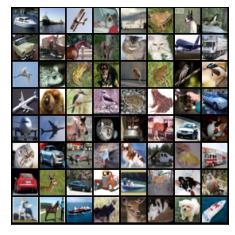

In [9]:
for batch in val_loader:
    (_, img2, img1), label = batch
    break
img_grid = make_grid(img1, normalize=True)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VisionF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


show(img_grid)

### Barlow Twins Loss

Here we define the loss function for Barlow Twins. It first normalizes the D dimensinonal vectors from the projection head and then computes the DxD cross-correlation matrix between the normalized vectors of the 2 views of each image.

Then it splits this cross-correlation matrix into two parts. The first part, the diagonal of this matrix is brought closer to 1, which pushes up the cosine similarity between the latent vectors of two views of each image, thus making the backbone invariant to the transformations applied to the views. The second part of the loss pushes the non-diagonal elements of the cross-corrlelation matrix closes to 0. This reduces the redundancy between the different dimensions of the latent vector.

In [ ]:
class BarlowTwinsLoss(nn.Module):
    def __init__(self, batch_size, lambda_coeff=5e-3, z_dim=8192):
        super().__init__()

        self.z_dim = z_dim
        self.batch_size = batch_size
        self.lambda_coeff = lambda_coeff

    def off_diagonal_ele(self, x):
        # taken from: https://github.com/facebookresearch/barlowtwins/blob/main/main.py
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z1, z2):
        # N x D, where N is the batch size and D is output dim of projection head
        z1_norm = (z1 - torch.mean(z1, dim=0)) / torch.std(z1, dim=0)
        z2_norm = (z2 - torch.mean(z2, dim=0)) / torch.std(z2, dim=0)

        cross_corr = torch.matmul(z1_norm.T, z2_norm) / self.batch_size

        on_diag = torch.diagonal(cross_corr).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal_ele(cross_corr).pow_(2).sum()

        return on_diag + self.lambda_coeff * off_diag

### Backbone

This is a standard Resnet backbone that we pre-train using the Barlow Twins method. To accommodate the 32x32 CIFAR10 images, we replace the first 7x7 convolution of the Resnet backbone by a 3x3 filter. We also remove the first Maxpool layer from the network for CIFAR10 images.

In [ ]:
encoder = resnet50()

# for CIFAR10, replace the first 7x7 conv with smaller 3x3 conv and remove the first maxpool
encoder.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
encoder.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)

# replace classification fc layer of Resnet to obtain representations from the backbone
encoder.fc = nn.Identity()

### Projection head

Unlike SimCLR and BYOL, the downstream performance of Barlow Twins greatly benefits from having a larger projection head after the backbone network. The paper utilizes a 3 layer MLP with 8192 hidden dimensions and 8192 as the output dimenion of the projection head. For our purpose we use a smaller projection head. But, it is imperative to mention here that in practice, Barlow Twins needs to be trained using a bigger projection head as it is highly sensitive to its architecture and output dimensionality.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=8192, output_dim=8192):
        super().__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(input_dim, hidden_dim, bias=True),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim, bias=False),
        )

    def forward(self, x):
        return self.projection_head(x)

### Learning rate warmup

For the purposes of this tutorial, we keep things simple and use a linear warmup schedule with Adam optimizer. In our previous experiments we have found that linear warmup part is much more important for the final performance of a model than the cosine decay component of the schedule.

In [ ]:
def fn(warmup_steps, step):
    if step < warmup_steps:
        return float(step) / float(max(1, warmup_steps))
    else:
        return 1.0


def linear_warmup_decay(warmup_steps):
    return partial(fn, warmup_steps)

### Barlow Twins Lightning Module

We keep the LightningModule for Barlow Twins neat and simple. It takes in an backbone encoder and initializes the projection head and the loss function. We configure the optimizer and the learning rate scheduler in the ``configure_optimizers`` method.

In [ ]:
loss_tr = []
loss_vl = []
class BarlowTwins(LightningModule):
    def __init__(
        self,
        encoder,
        encoder_out_dim,
        num_training_samples,
        batch_size,
        lambda_coeff=5e-3,
        z_dim=8192,
        learning_rate=1e-4,
        warmup_epochs=10,
        max_epochs=2000,
    ):
        super().__init__()

        self.encoder = encoder
        self.projection_head = ProjectionHead(input_dim=encoder_out_dim, hidden_dim=encoder_out_dim, output_dim=z_dim)
        self.loss_fn = BarlowTwinsLoss(batch_size=batch_size, lambda_coeff=lambda_coeff, z_dim=z_dim)

        self.learning_rate = learning_rate
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs

        self.train_iters_per_epoch = num_training_samples // batch_size

    def forward(self, x):
        return self.encoder(x)

    def shared_step(self, batch):
        (x1, x2, _), _ = batch
        z1 = self.projection_head(self.encoder(x1))
        z2 = self.projection_head(self.encoder(x2))

        return self.loss_fn(z1, z2)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=False)
        loss_tr.append(loss)
        return loss
        
        

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch)
        loss_vl.append(loss)
        self.log("val_loss", loss, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

        warmup_steps = self.train_iters_per_epoch * self.warmup_epochs

        scheduler = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0 = 10,
            ),
            "interval": "step",
            "frequency": 1,
        }

        return [optimizer], [scheduler]

### Evaluation

We define a callback which appends a linear layer on top of the encoder and trains the classification evaluation head in an online manner. We make sure not to backpropagate the gradients back to the encoder while tuning the linear layer. This technique was used in SimCLR as well and they showed that the final downstream classification peformance is pretty much similar to the results on online finetuning as the training progresses.

In [ ]:
class OnlineFineTuner(Callback):
    def __init__(
        self,
        encoder_output_dim: int,
        num_classes: int,
    ) -> None:
        super().__init__()

        self.optimizer: torch.optim.Optimizer

        self.encoder_output_dim = encoder_output_dim
        self.num_classes = num_classes

    def on_fit_start(self, trainer: pl.Trainer, pl_module: pl.LightningModule) -> None:

        # add linear_eval layer and optimizer
        pl_module.online_finetuner = nn.Linear(self.encoder_output_dim, self.num_classes).to(pl_module.device)
        self.optimizer = torch.optim.SGD(pl_module.online_finetuner.parameters(), lr=1e-4)

    def extract_online_finetuning_view(
        self, batch: Sequence, device: Union[str, torch.device]
    ) -> Tuple[Tensor, Tensor]:
        (_, _, finetune_view), y = batch
        finetune_view = finetune_view.to(device)
        y = y.to(device)

        return finetune_view, y

    def on_train_batch_end(
        self,
        trainer: pl.Trainer,
        pl_module: pl.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
        dataloader_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)
        
        
        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        acc = accuracy(F.softmax(preds, dim=1), y)
        pl_module.log("online_train_acc", acc, on_step=True, on_epoch=False)
        pl_module.log("online_train_loss", loss, on_step=True, on_epoch=False)

    def on_validation_batch_end(
        self,
        trainer: pl.Trainer,
        pl_module: pl.LightningModule,
        outputs: Sequence,
        batch: Sequence,
        batch_idx: int,
        dataloader_idx: int,
    ) -> None:
        x, y = self.extract_online_finetuning_view(batch, pl_module.device)

        with torch.no_grad():
            feats = pl_module(x)

        feats = feats.detach()
        preds = pl_module.online_finetuner(feats)
        loss = F.cross_entropy(preds, y)

        acc = accuracy(F.softmax(preds, dim=1), y)
        pl_module.log("online_val_acc", acc, on_step=False, on_epoch=True, sync_dist=True)
        pl_module.log("online_val_loss", loss, on_step=False, on_epoch=True, sync_dist=True)

Finally, we define the trainer for training the model. We pass in the ``train_loader`` and ``val_loader`` we had initialized earlier to the ``fit`` function.

In [ ]:
encoder_out_dim = 2048

model = BarlowTwins(
    encoder=encoder,
    encoder_out_dim=encoder_out_dim,
    num_training_samples=len(train_datasetf),
    batch_size=batch_size,
    z_dim=z_dim,
)

# online_finetuner = OnlineFineTuner(encoder_output_dim=encoder_out_dim, num_classes=10)
checkpoint_callback = ModelCheckpoint(every_n_epochs=100, save_top_k=-1, save_last=True)


ModelCheckpoint(save_last=True, save_top_k=-1, monitor=None) will duplicate the last checkpoint saved.


In [ ]:
epochs = 150
trainer = Trainer(
    max_epochs=epochs,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    callbacks=[checkpoint_callback]#[online_finetuner, checkpoint_callback],
)

# # uncomment this to train the model
# start = time.time()
# trainer.fit(model, train_loader, val_loader)
# time_taken = time.time() - start
# print(f"Time Taken : {time_taken}")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
ll = [i.item() for i in loss_tr]
# Calculating Training Loss
kk = []
iter = int(len(ll)/epochs)
for i in range(epochs):
  start = i*iter
  end = (i+1)*iter
  kk.append(sum(ll[start : end])/iter)

# Calculating Validation Losses
kk_vl = []
iter = int(len(lv)/epochs)
for i in range(epochs):
  start = i*iter
  end = (i+1)*iter
  kk_vl.append(sum(lv[start : end])/iter)
# Plotting the Losses
plt.plot(kk)
plt.plot(kk_vl)

In [ ]:
# # Save the Training Loss
# file = open("/content/gdrive/MyDrive/BarlowTwin_loss/loss.txt", "w") 
# str1 = repr(kk)
# file.write(str1)
# file.close()

In [ ]:
# # Save the Validation Loss
# file = open("/content/gdrive/MyDrive/BarlowTwin_loss/val_loss.txt", "w") 
# str1 = repr(kk_vl)
# file.write(str1)
# file.close()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# SAVING the model
model_save_name = 'classifier1000.pt'
path = F"/content/gdrive/MyDrive/BarlowTwin_loss/{model_save_name}" 
torch.save(model.state_dict(), path)

## Loss Propagation

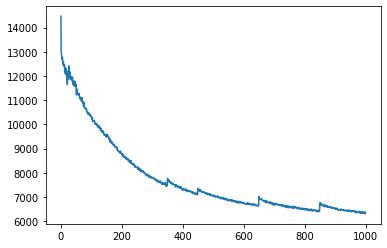

In [ ]:
# printing the data file to check the text in it  
with open("/content/gdrive/MyDrive/BarlowTwin_loss/loss.txt", 'r') as file:
    data = file.read().rstrip()
loss_previous = ast.literal_eval(data)
# loss_previous.extend(kk)
plt.plot(loss_previous)

In [ ]:
# # printing the data file to check the text in it
# with open("/content/gdrive/MyDrive/BarlowTwin_loss/val_loss.txt", 'r') as file:
#     data = file.read().rstrip()

# val_loss_previous = ast.literal_eval(data)
# val_loss_previous.extend(kk_vl)
# plt.plot(val_loss_previous)

In [ ]:
# # dont run this part of the code unknowingly
# # code snippet to delete the loss 
# f = open("/content/gdrive/MyDrive/BarlowTwin_loss/val_loss.txt", "r+")
# f.truncate(0)
# f.close()

# f = open("/content/gdrive/MyDrive/BarlowTwin_loss/loss.txt", "r+")
# f.truncate(0)
# f.close()

In [ ]:
# #save txt
# file = open("/content/gdrive/MyDrive/BarlowTwin_loss/loss.txt", "w") 
# str1 = repr(loss_previous)
# file.write(str1)
# file.close()
# #save txt
# file = open("/content/gdrive/MyDrive/BarlowTwin_loss/val_loss.txt", "w") 
# str2 = repr(val_loss_previous)
# file.write(str2)
# file.close()

### Using the trained encoder for downstream tasks

Once the encoder is pretrained on CIFAR10, we can use it to get image embeddings and use them further downstream on tasks like classification, detection, segmentation etc.


To create this checkpoint, the encoder was pretrained for 1000 epochs.

In [ ]:
# LOADING the model
model_save_name = 'classifier1000.pt'
path = F"/content/gdrive/MyDrive/BarlowTwin_loss/{model_save_name}"
model.load_state_dict(torch.load(path), strict = False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['online_finetuner.weight', 'online_finetuner.bias'])

## Downstream Task
Image Embeddings are stored and converted into dataset Classes For Classification Using a Linear layer

In [ ]:
test_embs=[]
test_labels=[]
for i,j in enumerate(test_loader1):
  test_embs.extend(model(j[0][2]).detach().numpy())
  test_labels.extend(j[1].detach().numpy())

In [ ]:
train_embs=[]
train_labels=[]
for i,j in enumerate(train_loader):
  train_embs.extend(model(j[0][2]).detach().numpy())
  train_labels.extend(j[1].detach().numpy())

In [ ]:
valid_embs=[]
valid_labels=[]
for i,j in enumerate(val_loader):
  valid_embs.extend(model(j[0][2]).detach().numpy())
  valid_labels.extend(j[1].detach().numpy())

## Defining Dataset Class

In [ ]:
class emb_set(Dataset):
    def __init__(self, train_emb, train_labels, transform=None, target_transform=None):
        self.embs=train_emb
        self.img_labels = train_labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.embs[idx]
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return torch.tensor(image), torch.tensor(label)

In [ ]:
train_emb_dataset=emb_set(train_embs,train_labels)
test_emb_dataset=emb_set(test_embs,test_labels)
valid_emb_dataset= emb_set(valid_embs, valid_labels)

In [ ]:
train_emb_loader=DataLoader(train_emb_dataset, batch_size=64, shuffle=True)
test_emb_loader=DataLoader(test_emb_dataset, batch_size=64, shuffle=True)
valid_emb_loader=DataLoader(valid_emb_dataset, batch_size=64, shuffle=True)

### Defining the Model for Classification

In [ ]:
class log_reg(torch.nn.Module):
      def __init__(self,inputSize,numClasses):
        super().__init__()
        self.linear = nn.Linear(inputSize, numClasses)
      def forward(self, xb): 
        xb = xb.reshape(-1, 2048) 
        out = self.linear(xb)
        return F.softmax(out)

#### Defining Hyper Parameters and Model

In [ ]:
batch_size = 64
epochs = 1000
input_dim = 2048
output_dim = 10
lr_rate = 0.1
logr_model=log_reg(2048,10) # Defining Model
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.SGD(logr_model.parameters(), lr=lr_rate)
scheduler=lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 20, 2)

#### Training

In [ ]:
iter = 0
loss_lin_tr = []
mac_acc = []
acc = []
for epoch in range(int(epochs)):
    for i, (images, labels) in enumerate(train_emb_loader):
        images = Variable(images.view(-1, 2048))
        labels = Variable(labels)

        optimizer.zero_grad()
        outputs = logr_model(images)
        loss = criterion(outputs, labels)
        loss_lin_tr.append(loss)
        loss.backward()
        optimizer.step()

        iter+=1
        if iter%500==0:
            # calculate Accuracy
            correct = 0
            total = 0
            predicts = torch.Tensor([])
            actuals = torch.Tensor([])
            for i, (images, labels) in enumerate(valid_emb_loader):
                images = Variable(images.view(-1, 2048))
                outputs = logr_model(images)
                _, predicted = torch.max(outputs.data, 1)
                predicts = torch.cat((predicts,predicted))
                actuals = torch.cat((actuals,labels))
                total+= labels.size(0)
                # for gpu, bring the predicted and labels back to cpu fro python operations to work
                correct+= (predicted == labels).sum()
            accuracy = 100 * correct/total
            macro_acc = 100* f1_score(predicts , actuals , average = "macro")
            mac_acc.appened(macro_acc)
    
            print("Iteration: %d. Loss: %.2f. Accuracy: %.2f%%. Macro Accuracy %.2f%%."% (iter, loss.item(), accuracy , macro_acc))
    scheduler.step(20)

Iteration: 500. Loss: 1.70. Accuracy: 64.17%. Macro Accuracy 61.31%.
Iteration: 1000. Loss: 1.77. Accuracy: 66.15%. Macro Accuracy 65.72%.
Iteration: 1500. Loss: 1.68. Accuracy: 67.81%. Macro Accuracy 67.74%.
Iteration: 2000. Loss: 1.68. Accuracy: 67.71%. Macro Accuracy 67.58%.
Iteration: 2500. Loss: 1.62. Accuracy: 68.02%. Macro Accuracy 68.24%.
Iteration: 3000. Loss: 1.66. Accuracy: 67.40%. Macro Accuracy 67.56%.
Iteration: 3500. Loss: 1.66. Accuracy: 67.29%. Macro Accuracy 67.03%.
Iteration: 4000. Loss: 1.65. Accuracy: 68.33%. Macro Accuracy 68.17%.
Iteration: 4500. Loss: 1.63. Accuracy: 67.81%. Macro Accuracy 67.66%.
Iteration: 5000. Loss: 1.56. Accuracy: 67.92%. Macro Accuracy 67.75%.
Iteration: 5500. Loss: 1.65. Accuracy: 67.40%. Macro Accuracy 67.60%.
Iteration: 6000. Loss: 1.63. Accuracy: 67.50%. Macro Accuracy 67.44%.
Iteration: 6500. Loss: 1.67. Accuracy: 68.23%. Macro Accuracy 68.24%.
Iteration: 7000. Loss: 1.61. Accuracy: 67.92%. Macro Accuracy 67.89%.
Iteration: 7500. Loss

#### Testing

In [ ]:
correct = 0
total = 0
predicts = torch.Tensor([])
actuals = torch.Tensor([])
for i, (images, labels) in enumerate(test_emb_loader):
    images = Variable(images.view(-1, 2048))
    outputs = logr_model(images)
    _, predicted = torch.max(outputs.data, 1)
    total+= labels.size(0)
    predicts = torch.cat((predicts,predicted))
    actuals = torch.cat((actuals,labels))
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct+= (predicted == labels).sum()
accuracy = 100 * correct/total
macro_acc = 100*f1_score(predicts , actuals , average = "macro")
print("Testing Accuracy: %.2f%%.Macro Accuracy %.2f%%."% (accuracy,macro_acc))

Testing Accuracy: 66.44%.Macro Accuracy 66.31%.


### Loss Propagation

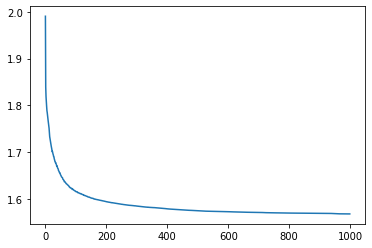

In [ ]:
losses = [i.item() for i in loss_lin_tr]
# Calculating Training Loss
final_loss = []
iter = int(len(losses)/epochs)
for i in range(epochs):
  start = i*iter
  end = (i+1)*iter
  final_loss.append(sum(losses[start : end])/iter)

plt.plot(final_loss)

---
Supervised Classification

Resnet 50 

---




In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Defining the network

In [11]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])


def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])

### Transforming the Dataset for Resnet

In [12]:
class trainTransformA:
    def __init__(self, train=True, input_height=224, gaussian_blur=True, jitter_strength=1.0, normalize=None):

        self.input_height = input_height
        self.gaussian_blur = gaussian_blur
        self.jitter_strength = jitter_strength
        self.normalize = normalize
        self.train = train

        color_jitter = transforms.ColorJitter(
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.8 * self.jitter_strength,
            0.2 * self.jitter_strength,
        )

        color_transform = [transforms.RandomApply([color_jitter], p=0.8), transforms.RandomGrayscale(p=0.2)]

        if self.gaussian_blur:
            kernel_size = int(0.1 * self.input_height)
            if kernel_size % 2 == 0:
                kernel_size += 1

            color_transform.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=kernel_size)], p=0.5))

        self.color_transform = transforms.Compose(color_transform)

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                transforms.RandomResizedCrop(self.input_height),
                transforms.RandomHorizontalFlip(p=0.5),
                self.color_transform,
                self.final_transform,
            ]
        )

        self.finetune_transform = None
        if self.train:
            self.finetune_transform = transforms.Compose(
                [
                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ]
            )
        else:
            self.finetune_transform = transforms.ToTensor()

    def __call__(self, sample):
        return self.finetune_transform(sample)

In [13]:
class trainTransform:
    def __init__(self, input_height=224, normalize=None):

        self.input_height = input_height
        self.normalize = normalize

        if normalize is None:
            self.final_transform = transforms.ToTensor()
        else:
            self.final_transform = transforms.Compose([transforms.ToTensor(), normalize])

        self.transform = transforms.Compose(
            [
                self.final_transform
            ]
        )


    def __call__(self, sample):
        return self.transform(sample)


def cifar10_normalization():
    normalize = transforms.Normalize(
        mean=[x / 255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]]
    )
    return normalize

## Augmented Dataset

In [14]:
batch_size = 64

train_transform = trainTransformA(
    train=True, input_height=32, gaussian_blur=False, jitter_strength=False, normalize=cifar10_normalization()
)

train_dataseta = CIFAR10(root=".", train=True, download=True, transform=train_transform)

train_set_size = 40000
valid_set_size = 10000
train_dataset, valid_dataset = data_utils.random_split(train_dataseta, [train_set_size, valid_set_size],generator = torch.Generator().manual_seed(2022))


test_transform = trainTransformA(
    train=False, input_height=32, gaussian_blur=False, jitter_strength=False, normalize= None
)

test_dataset = CIFAR10(root=".", train=False, download=True, transform = test_transform)

test_loader2 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
train_datasetf2 = data_utils.Subset(train_dataset , indices_train)
valid_datasetf2 = data_utils.Subset(valid_dataset , indices_val)

train_loaderR = DataLoader(train_datasetf2, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, )
val_loaderR = DataLoader(valid_datasetf2, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

## Not Augmented Data

In [14]:
batch_size = 64

train_transform = trainTransform(
    input_height=32, normalize=cifar10_normalization()
)

train_dataset = CIFAR10(root=".", train=True, download=True, transform=train_transform)

train_set_size = 40000
valid_set_size = 10000
train_dataset, valid_dataset = data_utils.random_split(train_dataset, [train_set_size, valid_set_size],generator = torch.Generator().manual_seed(2022))


test_transform = trainTransform(
    input_height=32, normalize= None
)

test_dataset = CIFAR10(root=".", train=False, download=True, transform = test_transform)

test_loader1 = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
train_datasetf1 = data_utils.Subset(train_dataset , indices_train)
valid_datasetf1 = data_utils.Subset(valid_dataset , indices_val)

train_loaderR = DataLoader(train_datasetf1, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True, )
val_loaderR = DataLoader(valid_datasetf1, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=True)

In [16]:
import os

print('==> Building model..')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet50()
net = net.to(device)


==> Building model..


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [18]:
train_acc = []
val_acc = []
best_acc = 0.0
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    loss_train = []
    actuals = torch.Tensor([]).to("cuda:0")
    predicts = torch.Tensor([]).to("cuda:0")
    for batch_idx, (inputs, targets) in enumerate(train_loaderR):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss_train.append(loss)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        predicts = torch.cat((predicts,predicted))
        actuals = torch.cat((actuals,targets))

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        # if batch_idx % 20 == 19:
        #     print('[%d/%d] Loss: %.3f | Acc: %.3f%% (%d/%d)'% (batch_idx, len(train_loader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    ll = [i.item() for i in loss_train]
    loss = sum(ll)/(batch_idx + 1)

    accuracy = 100*f1_score(predicts.cpu() , actuals.cpu() , average = "micro")
    macro_acc = 100*f1_score(predicts.cpu() , actuals.cpu() , average = "macro")
    print("Training \nLoss: %.2f .\nAccuracy: %.2f%%.\nMacro Accuracy %.2f%%.\n"% (loss ,accuracy,macro_acc))
    return accuracy , loss

def validation(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    predicts = torch.Tensor([]).to("cuda:0")
    actuals = torch.Tensor([]).to("cuda:0")
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loaderR):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            predicts = torch.cat((predicts,predicted))
            actuals = torch.cat((actuals,targets))

            correct += predicted.eq(targets).sum().item()
    acc = 100*f1_score(actuals.cpu(),predicts.cpu() , average = "micro")
    macro_acc = 100*f1_score(actuals.cpu(),predicts.cpu() , average = "macro")
    print("Validation \nAccuracy %.2f%%.\nMacro Accuracy %.2f%%."% (acc,macro_acc))
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    return acc

In [19]:
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
Train_loss = []
Train_acc = []
Val_acc = []
for epoch in range(start_epoch, start_epoch+75):
    acc , loss = train(epoch)
    Train_loss.append(loss)
    Train_acc.append(acc)
    Val_acc.append(validation(epoch))


Epoch: 0
Training 
Loss: 2.14 .
Accuracy: 20.88%.
Macro Accuracy 20.49%.

Validation 
Accuracy 29.69%.
Macro Accuracy 26.99%.
Saving..

Epoch: 1
Training 
Loss: 1.80 .
Accuracy: 32.06%.
Macro Accuracy 31.68%.

Validation 
Accuracy 37.05%.
Macro Accuracy 33.68%.
Saving..

Epoch: 2
Training 
Loss: 1.60 .
Accuracy: 41.02%.
Macro Accuracy 40.61%.

Validation 
Accuracy 40.02%.
Macro Accuracy 38.31%.
Saving..

Epoch: 3
Training 
Loss: 1.45 .
Accuracy: 47.14%.
Macro Accuracy 46.76%.

Validation 
Accuracy 44.30%.
Macro Accuracy 44.33%.
Saving..

Epoch: 4
Training 
Loss: 1.33 .
Accuracy: 52.24%.
Macro Accuracy 51.98%.

Validation 
Accuracy 45.26%.
Macro Accuracy 44.68%.
Saving..

Epoch: 5
Training 
Loss: 1.16 .
Accuracy: 58.36%.
Macro Accuracy 58.15%.

Validation 
Accuracy 46.42%.
Macro Accuracy 45.28%.
Saving..

Epoch: 6
Training 
Loss: 0.98 .
Accuracy: 64.75%.
Macro Accuracy 64.53%.

Validation 
Accuracy 48.99%.
Macro Accuracy 48.04%.
Saving..

Epoch: 7
Training 
Loss: 0.83 .
Accuracy: 70.04

KeyboardInterrupt: ignored

56.09879032258065


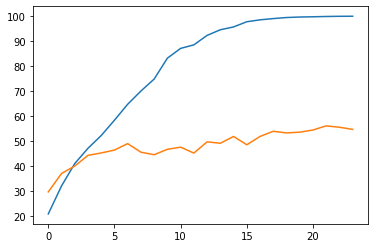

In [20]:
print(best_acc)
plt.plot(Train_acc)
plt.plot(Val_acc)

In [21]:
net.eval()
correct = 0
total = 0
predicts = torch.Tensor([]).to("cuda:0")
actuals = torch.Tensor([]).to("cuda:0")
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(test_loader1):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)

        _, predicted = outputs.max(1)
        total += targets.size(0)
        predicts = torch.cat((predicts,predicted))
        actuals = torch.cat((actuals,targets))
        correct += predicted.eq(targets).sum().item()
print('Testing Accuracy: %.2f%% (%d/%d)' % (100.*correct/total, correct, total))
macro_acc = 100*f1_score(actuals.cpu(),predicts.cpu() , average = "macro")
print("Testing Macro Accuracy %.2f%%."% (macro_acc))

Testing Accuracy: 16.39% (1636/9984)
Testing Macro Accuracy 10.59%.


## Res-Net 18 

In [ ]:
print('==> Building model..')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet18()
net = net.to(device)


==> Building model..


In [ ]:
best_acc = 0.0
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
Train_loss = []
Train_acc = []
Val_acc = []
for epoch in range(start_epoch, start_epoch+50):
    acc , loss = train(epoch)
    Train_loss.append(loss)
    Train_acc.append(acc)
    Val_acc.append(validation(epoch))


Epoch: 0
Training 
Loss: 2.33 .
Accuracy: 7.51%.
Macro Accuracy 5.79%.

Validation 
Accuracy 7.29%.
Macro Accuracy 5.21%.
Saving..

Epoch: 1
Training 
Loss: 2.34 .
Accuracy: 7.56%.
Macro Accuracy 5.62%.

Validation 
Accuracy 6.98%.
Macro Accuracy 5.29%.

Epoch: 2
Training 
Loss: 2.34 .
Accuracy: 7.81%.
Macro Accuracy 5.76%.

Validation 
Accuracy 7.08%.
Macro Accuracy 5.15%.

Epoch: 3
Training 
Loss: 2.34 .
Accuracy: 7.28%.
Macro Accuracy 5.36%.

Validation 
Accuracy 8.12%.
Macro Accuracy 6.05%.
Saving..

Epoch: 4
Training 
Loss: 2.33 .
Accuracy: 7.43%.
Macro Accuracy 5.65%.

Validation 
Accuracy 6.46%.
Macro Accuracy 5.09%.

Epoch: 5
Training 
Loss: 2.34 .
Accuracy: 6.65%.
Macro Accuracy 4.76%.

Validation 
Accuracy 7.50%.
Macro Accuracy 6.34%.

Epoch: 6
Training 
Loss: 2.34 .
Accuracy: 8.37%.
Macro Accuracy 6.27%.

Validation 
Accuracy 7.19%.
Macro Accuracy 5.49%.

Epoch: 7
Training 
Loss: 2.33 .
Accuracy: 8.11%.
Macro Accuracy 5.99%.

Validation 
Accuracy 6.35%.
Macro Accuracy 4.61%

8.75


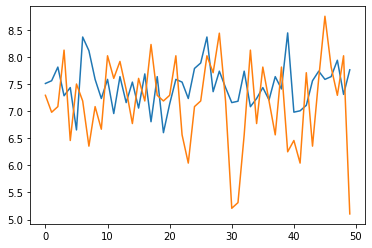

In [ ]:
print(best_acc)
plt.plot(Train_acc)
plt.plot(Val_acc)

## Res-Net 152

In [ ]:
print('==> Building model..')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = ResNet152()
net = net.to(device)


==> Building model..


In [ ]:
best_acc = 0.0
start_epoch = 0 # start from epoch 0 or last checkpoint epoch
Train_loss = []
Train_acc = []
Val_acc = []
for epoch in range(start_epoch, start_epoch+30):
    acc , loss = train(epoch)
    Train_loss.append(loss)
    Train_acc.append(acc)
    Val_acc.append(validation(epoch))


Epoch: 0
Training 
Loss: 2.50 .
Accuracy: 10.69%.
Macro Accuracy 1.93%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.
Saving..

Epoch: 1
Training 
Loss: 2.51 .
Accuracy: 10.61%.
Macro Accuracy 1.92%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

Epoch: 2
Training 
Loss: 2.51 .
Accuracy: 10.64%.
Macro Accuracy 1.92%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

Epoch: 3
Training 
Loss: 2.51 .
Accuracy: 10.61%.
Macro Accuracy 1.92%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

Epoch: 4
Training 
Loss: 2.51 .
Accuracy: 10.61%.
Macro Accuracy 1.92%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

Epoch: 5
Training 
Loss: 2.51 .
Accuracy: 10.64%.
Macro Accuracy 1.92%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

Epoch: 6
Training 
Loss: 2.51 .
Accuracy: 10.56%.
Macro Accuracy 1.91%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

Epoch: 7
Training 
Loss: 2.51 .
Accuracy: 10.58%.
Macro Accuracy 1.91%.

Validation 
Accuracy 9.48%.
Macro Accuracy 1.73%.

9.479166666666666


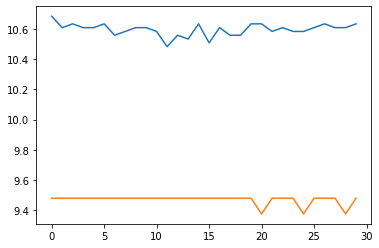

In [ ]:
print(best_acc)
plt.plot(Train_acc)
plt.plot(Val_acc)